In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

Loading 2026-02-02_config.yaml


In [4]:
data_config = config['dataset'].copy()
data_config

data_config['examples']['subjects'] = 'one_subject.csv'
#data_config['examples']['subjects'] = 'two_subjects.csv'
#data_config['examples']['subjects'] = 'ten_subjects.csv'
#data_config['examples']['subjects'] = '100_subjects.csv'
#data_config['examples']['subjects'] = '2026-01-26_preprocessed.csv'


In [5]:
%autoreload
# example selection
# wss.1f5c74f0a55cbf9798d5fc0473d00a1c - nan with 1e-5 reg weight
# wss.1e5abf0465d97d826118a17db9de8c0 - vase

ex = project.api.get_examples(data_config)[0]
pprint(ex, max_depth=1)

Gathering examples
Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.100f39dce7690f59efb94709f30ce0d2'
├── variant:  '2026-01-15'
├── paths:    dict(len=13)
└── metadata: dict(len=4)


Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_density.nii.gz


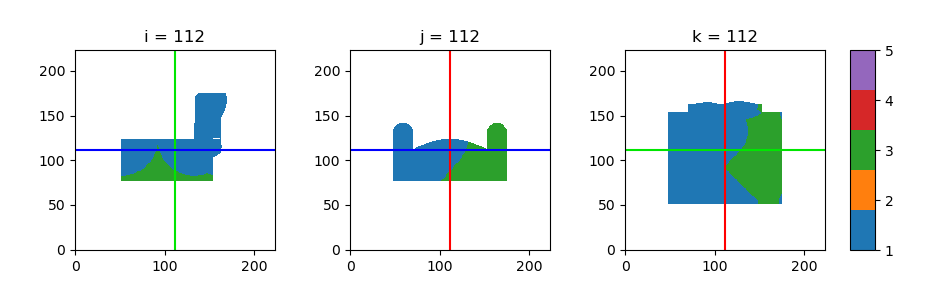

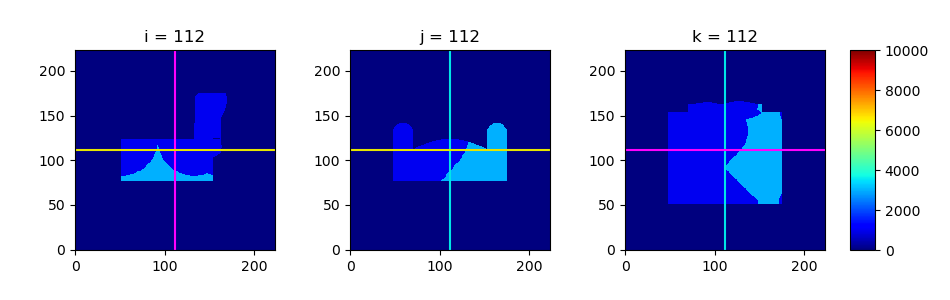

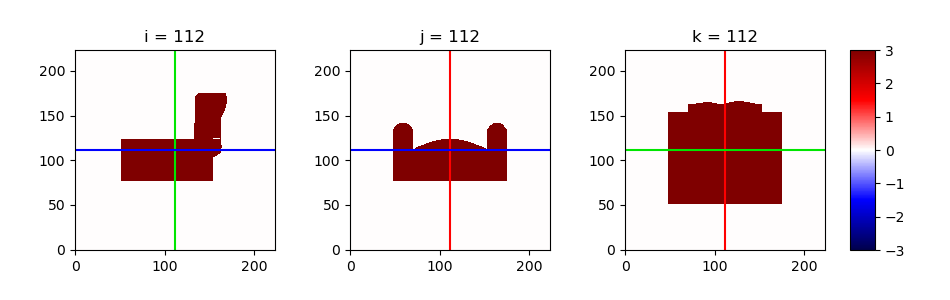

In [6]:
%autoreload
import project.visual.matplotlib as mpl_viz

mask = project.core.fileio.load_nibabel(ex.paths['material_mask']).get_fdata()
E_true = project.core.fileio.load_nibabel(ex.paths['elastic_field']).get_fdata()
d_true = project.core.fileio.load_nibabel(ex.paths['density_field']).get_fdata()

mpl_viz.SliceViewer(mask, **mpl_viz.get_color_kws('material', n_labels=5))
mpl_viz.SliceViewer(E_true, **mpl_viz.get_color_kws('E_true'))
mpl_viz.SliceViewer(d_true, **mpl_viz.get_color_kws('d_true'))

In [7]:
opt_config = config['optimization'].copy()
opt_config['targets'] = ['E', 'nu', 'rho']
opt_config['optimizer']['global_steps'] = 10
opt_config['optimizer']['local_steps'] = 10
opt_config['pde_solver']['eps_div'] = 1e-6
pprint(opt_config, max_depth=3)

dict(len=5)
├── 'targets':         list(len=3)
|   ├── 0: 'E'
|   ├── 1: 'nu'
|   └── 2: 'rho'
├── 'param_specs':     dict(len=3)
|   ├── 'E':   dict(len=3)
|   |   ├── 'mode': 'log10'
|   |   ├── 'mean': 3.4863
|   |   └── 'std':  0.3271
|   ├── 'nu':  dict(len=3)
|   |   ├── 'mode': 'logit'
|   |   ├── 'min':  0.0
|   |   └── 'max':  0.5
|   └── 'rho': dict(len=3)
|       ├── 'mode': 'log10'
|       ├── 'mean': 3.0
|       └── 'std':  0.1
├── 'physics_adapter': dict(len=4)
|   ├── 'default_nu':    0.4
|   ├── 'default_rho':   1000
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=4)
|   ├── '_class':        'WarpFEMSolver'
|   ├── 'relative_loss': True
|   ├── 'tv_reg_weight': 0.0001
|   └── 'eps_div':       1e-06
└── 'optimizer':       dict(len=7)
    ├── '_class':         'LBFGS'
    ├── 'lr':             1.0
    ├── 'max_iter':       100
    ├── 'history_size':   10
    ├── 'line_search_fn': 'strong_wolfe'
    ├── 'global_steps':   10
    └── 'l

In [8]:
%%time
import project.optimization
from pathlib import Path

output_path = Path('optimized.xdmf')
raster_base = Path('raster')

metrics = project.optimization.optimize_example(ex, opt_config, output_path, raster_base)
metrics

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_no-noise.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_no-noise_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_density.nii.gz
Targets: ['E', 'nu', 'rho']
Stage 1: Global optimization
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	2.6146e-01 (nan)	7.3728e-06 (1.0000e

In [9]:
mesh = project.core.fileio.load_meshio(output_path)
pv_mesh = pv.wrap(mesh)
pv_mesh

Loading optimized.xdmf


UnstructuredGrid (0x14b1e4906200)
  N Cells:    31485
  N Points:   7115
  X Bounds:   1.577e+02, 2.437e+02
  Y Bounds:   1.084e+01, 9.014e+01
  Z Bounds:   -4.355e-02, 6.656e+01
  N Arrays:   32

In [10]:
import project.visual.pyvista as pv_viz
pv_viz.plot_mesh(mesh, scalar='E_pred', cmap='jet', clim=(0, 1e4)).show()

2026-02-18 11:12:59.299 ( 254.022s) [    14B321DDF200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14b165652910_0" src="https://ondemand.bridges2.p…

Loading raster/E_pred.nii.gz
Loading raster/nu_pred.nii.gz
Loading raster/rho_pred.nii.gz


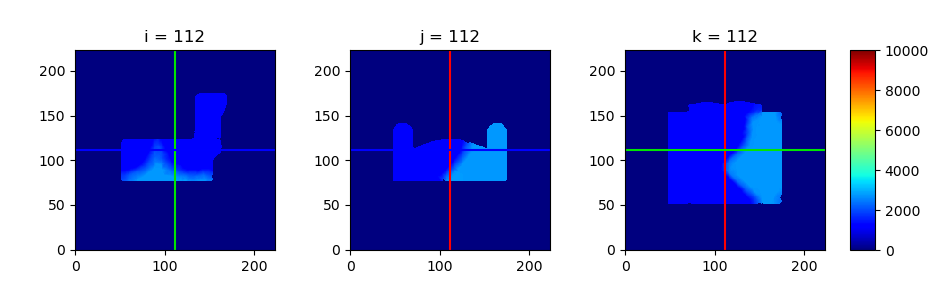

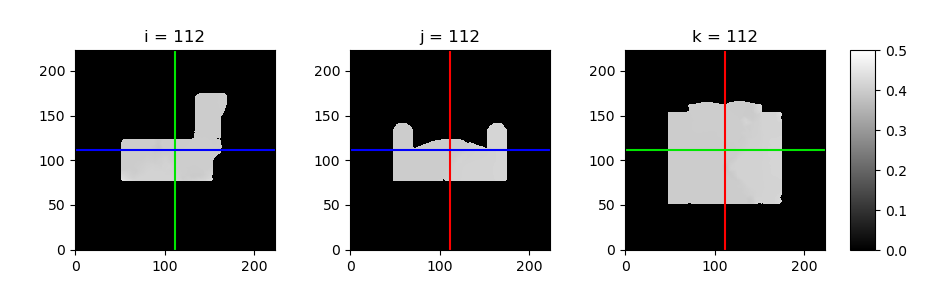

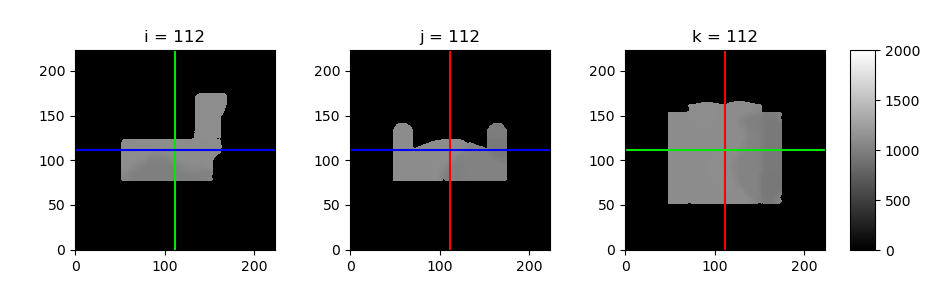

In [11]:
import project.visual.matplotlib as mpl_viz
nifti = project.core.fileio.load_nibabel(raster_base / 'E_pred.nii.gz')
mpl_viz.SliceViewer(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(raster_base / 'nu_pred.nii.gz')
mpl_viz.SliceViewer(nifti.get_fdata(), cmap='gray', clim=(0, 0.5))

nifti = project.core.fileio.load_nibabel(raster_base / 'rho_pred.nii.gz')
mpl_viz.SliceViewer(nifti.get_fdata(), cmap='gray', clim=(0, 2e3))

In [12]:
# debugging optimize_example()

sample = project.datasets.torch.TorchDataset([ex])[0]
mesh   = sample['mesh']
unit_m = float(ex.metadata['unit'])
affine = sample['affine']
mask   = sample['mask']

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_no-noise.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_no-noise_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_density.nii.gz


In [13]:
import project.physics

physics_adapter_kws = opt_config.get('physics_adapter', {})
pprint(physics_adapter_kws)

pde_solver_kws = opt_config.get('pde_solver', {}).copy()
pde_solver_kws['relative_loss'] = True
pprint(pde_solver_kws)

pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **physics_adapter_kws
)
physics_adapter.device

dict(len=4)
├── 'default_nu':    0.4
├── 'default_rho':   1000
├── 'scalar_degree': 1
└── 'vector_degree': 1
dict(len=4)
├── '_class':        'WarpFEMSolver'
├── 'relative_loss': True
├── 'tv_reg_weight': 0.0001
└── 'eps_div':       1e-06


'cuda'

In [14]:
import project.models

opt_targets = ['E', 'nu', 'rho']

param_specs_cfg = opt_config.get('param_specs', {})
pprint(param_specs_cfg)

param_specs = {}
for name in opt_targets:
    spec_kws = param_specs_cfg[name]
    param_specs[name] = project.models.ParameterSpec(**spec_kws)

param_specs

dict(len=3)
├── 'E':   dict(len=3)
|   ├── 'mode': 'log10'
|   ├── 'mean': 3.4863
|   └── 'std':  0.3271
├── 'nu':  dict(len=3)
|   ├── 'mode': 'logit'
|   ├── 'min':  0.0
|   └── 'max':  0.5
└── 'rho': dict(len=3)
    ├── 'mode': 'log10'
    ├── 'mean': 3.0
    └── 'std':  0.1


{'E': <project.models.ParameterSpec at 0x14b1640df510>,
 'nu': <project.models.ParameterSpec at 0x14b1c49fc310>,
 'rho': <project.models.ParameterSpec at 0x14b1c4997050>}

In [15]:
# initialize free dofs
z_vars = {}
for name, spec in param_specs.items():
    z0 = physics_adapter.init_param_field(mesh, unit_m)
    z_vars[name] = torch.nn.Parameter(z0)

z_vars

{'E': Parameter containing:
 tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True),
 'nu': Parameter containing:
 tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True),
 'rho': Parameter containing:
 tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)}

In [114]:
%%time
# run optimization

optimizer_kws = opt_config.get('optimizer', {}).copy()
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))

params = project.optimization.optimize_params_two_stage(
    physics_adapter=physics_adapter,
    mesh=mesh,
    unit_m=unit_m,
    bc_spec=None,
    z_vars=z_vars,
    param_specs=param_specs,
    optimizer_cls=optimizer_cls,
    optimizer_kws=optimizer_kws,
    global_steps=0,
    local_steps=10
)
params

Stage 1: Global optimization
Stage 2: Local optimization
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	2.6174e-01 (nan)	4.9172e-05 (1.0000e+00)	9.2228e+01 (nan)
1	1.6042e-04 (9.9939e-01)	9.8781e-06 (2.0089e-01)	1.0347e+02 (4.0428e-01)
2	8.6084e-05 (4.6338e-01)	1.1410e-05 (2.3203e-01)	1.1031e+02 (1.8948e-01)
3	6.7726e-05 (2.1325e-01)	1.1811e-05 (2.4020e-01)	1.1293e+02 (8.1796e-02)
4	6.1639e-05 (8.9878e-02)	1.1736e-05 (2.3868e-01)	1.1557e+02 (7.9918e-02)
5	5.6808e-05 (7.8384e-02)	1.1319e-05 (2.3019e-01)	1.1875e+02 (7.9064e-02)
6	5.2841e-05 (6.9823e-02)	1.1628e-05 (2.3647e-01)	1.2138e+02 (5.6574e-02)
7	4.9616e-05 (6.1032e-02)	1.0481e-05 (2.1315e-01)	1.2313e+02 (3.7954e-02)
8	4.7521e-05 (4.2223e-02)	9.4061e-06 (1.9129e-01)	1.2439e+02 (3.1224e-02)
9	4.5833e-05 (3.5537e-02)	1.0101e-05 (2.0543e-01)	1.2508e+02 (2.1227e-02)
CPU times: user 1min 41s, sys: 3min 42s, total: 5min 23s
Wall time: 1min 25s


{'E': tensor([1920.7006, 1500.2543, 2465.4543,  ..., 2604.3408, 2494.3171,
         2096.9912]),
 'nu': tensor([0.4452, 0.4076, 0.2908,  ..., 0.3630, 0.3758, 0.4044]),
 'rho': tensor([ 784.1255,  998.8829, 1065.2886,  ..., 1050.0522,  749.6374,
          794.1671])}

In [115]:
loss, sim_output = physics_adapter.mesh_simulation_loss(
    mesh=mesh,
    unit_m=unit_m,
    params=params,
    bc_spec=None,
    ret_outputs=True
)
loss.item()

4.445811646291986e-05

In [133]:
# run evaluation
import project.evaluation

evaluator_kws = opt_config.get('evaluator', {})
evaluator = project.evaluation.EvaluatorCallback(**evaluator_kws)

outputs = {
    'example': [ex],
    'sim': [sim_output],
    'loss': loss
}
evaluator.evaluate(epoch=0, phase='optimize', batch=0, step=0, outputs=outputs)
evaluator.on_phase_end(epoch=0, phase='optimize')

Cannot estimate material map from provided outputs.


Saving outputs/example_metrics.csv
Saving outputs/material_metrics.csv
Optimize metrics @ epoch 0: 
   epoch     phase  batch  step      loss  \
0      0  optimize      0     0  0.000044   

                                subject  num_cells    volume  u_cell.mean  \
0  wss.100f39dce7690f59efb94709f30ce0d2      31485  0.507446     0.034107   

   u_cell.rms  ...  mu_cell.scorr  nu_cell.mean  nu_cell.rms  rho_cell.mean  \
0    0.042609  ...       0.835306      0.348253     0.352289    1108.367692   

   rho_cell.rms  rho_cell.rmse  rho_cell.nrmse  rho_cell.srmse  \
0   1124.707369     219.616218        0.219616             NaN   

   rho_cell.pcorr  rho_cell.scorr  
0             NaN             NaN  

[1 rows x 47 columns]


In [103]:
%autoreload
# debugging optimize_params()

def decode_local():
    return {k: spec.decode(z_vars[k]) for k, spec in param_specs.items()}

def decode_global():
    return {k: dofs.mean().expand(dofs.shape) for k, dofs in decode_local().items()}

def objective(params):
    return physics_adapter.mesh_simulation_loss(
        mesh=mesh,
        unit_m=unit_m,
        params=params,
        bc_spec=None
    )

optimizer = optimizer_cls(list(z_vars.values()), **optimizer_kws)
history = project.optimization.OptimizationHistory()

def closure():
    optimizer.zero_grad()
    params = decode_local()
    loss = objective(params)
    loss.backward()
    return loss

project.optimization.optimize_closure(optimizer, closure, max_steps=10)

iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
iter	loss (rel_delta)	grad_norm (rel_init)	param_norm (update_norm)
0	9.0576e-05 (nan)	1.2077e-11 (1.0000e+00)	9.7678e+01 (nan)
1	9.0576e-05 (0.0000e+00)	1.2077e-11 (1.0000e+00)	9.7678e+01 (0.0000e+00)
Optimization converged


tensor([9.0576e-05], device='cuda:0', grad_fn=<PDELossFnBackward>)

In [73]:
optimizer_kws = opt_config.get('optimizer', {}).copy()
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))

In [65]:
import project.optimization

params = project.optimization.optimize_params_two_stage(
    physics_adapter=physics_adapter,
    mesh=mesh,
    unit_m=unit_m,
    affine=affine,
    bc_spec=None,
    z_vars=z_vars,
    param_specs=param_specs,
    optimizer_cls=optimizer_cls,
    optimizer_kws=optimizer_kws,
)

Stage 1: Global optimization
Stage 2: Local optimization


In [68]:
params

{'E': tensor([3064.0793, 3064.0793, 3064.0793,  ..., 3064.0793, 3064.0793,
         3064.0793]),
 'nu': tensor([0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500])}

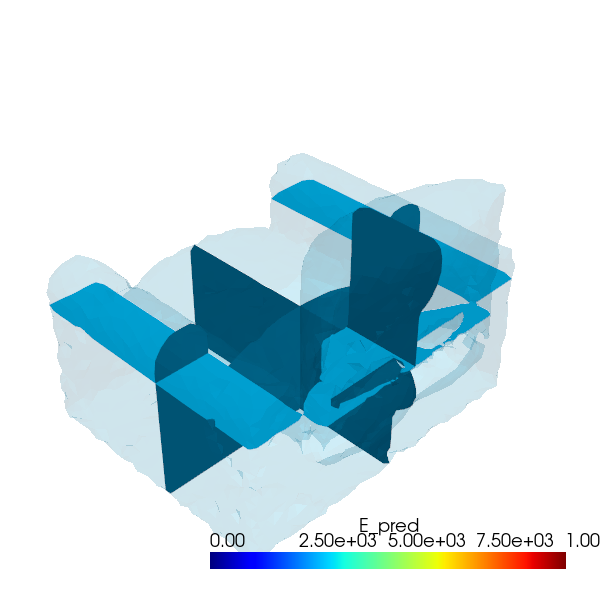

In [70]:
size = 600
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_pred', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_pred', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

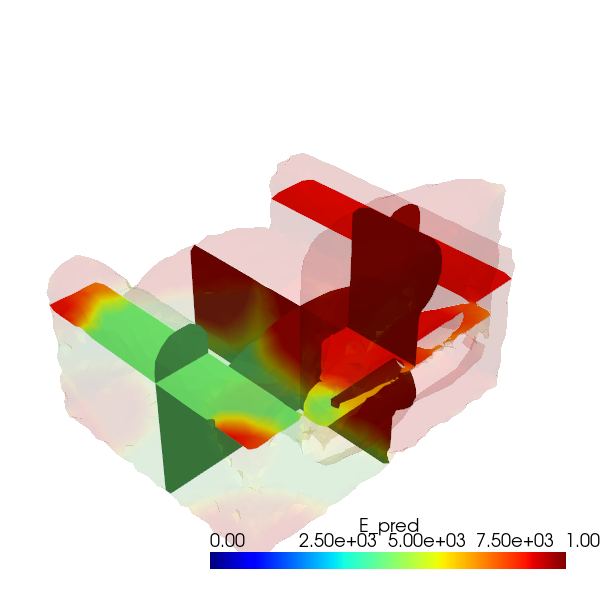

In [29]:
p = pv.Plotter(window_size=(size,size))
p.add_mesh(pv_mesh, scalars='E_pred', cmap='jet', opacity=0.1, clim=(0,1e4))
p.add_mesh(pv_mesh.slice_orthogonal(), scalars='E_pred', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_material.nii.gz
Loading ../../data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_material_elastic.nii.gz
Loading outputs/optimize/wss.100f39dce7690f59efb94709f30ce0d2/niftis/optimized.nii.gz


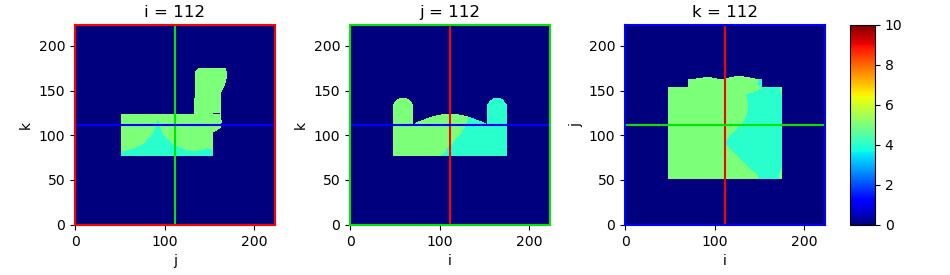

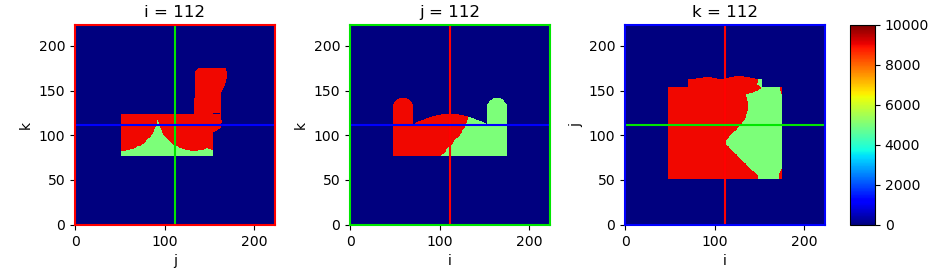

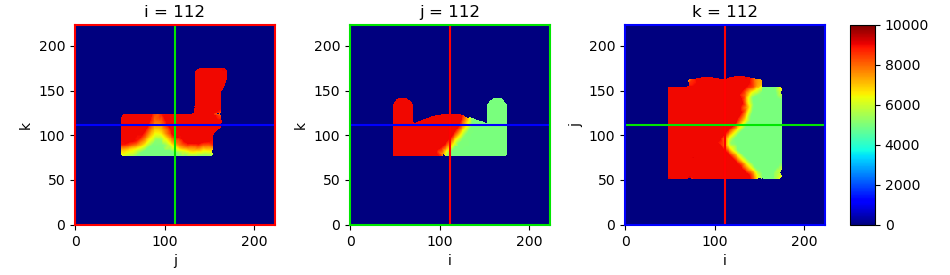

In [30]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['material_mask'])
mask = nifti.get_fdata().astype(int)
_ = project.visual.matplotlib.show_image_slices(mask, cmap='jet', clim=(0, 10))

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
E_true = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_true, cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(raster_path)
E_pred = nifti.get_fdata()
_ = project.visual.matplotlib.show_image_slices(E_pred, cmap='jet', clim=(0, 1e4))

In [42]:
pd.read_csv('outputs/example_metrics.csv')

,epoch,phase,batch,step,loss,subject,num_voxels,E_vox.mean,E_vox.rms,E_vox.rmse,...,E_cell.scorr,u_cell.mean,u_cell.rms,u_cell.rmse,u_cell.nrmse,u_cell.srmse,u_cell.pcorr,u_cell.scorr,res_cell.mean,res_cell.rms
0,0,optimize,0,0,0.000051,wss.100f39dce7690f59efb94709f30ce0d2,778627,7591.852874,7817.06595,764.623532,...,0.82281,0.006504,0.007865,0.000008,0.001068,0.001899,0.999999,0.999979,0.434869,0.805458


In [44]:
pd.read_csv('outputs/material_metrics.csv')['mat_vox.dice']

0    0.975979
1    0.987764
Name: mat_vox.dice, dtype: float64

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)